# Building Automated Evaluations for Amazon Bedrock Guardrails

In the prior notebooks we illustrated different Guardrails types and how they can safeguard your generative AI application.

In this notebook we will walk through how to create evaluations for these Guardrails to help ensure that they are working as intended. This notebook has the following sections:

- 1. Create Amazon Bedrock Guardrails 
- 2. Create a test dataset based on the application use case and its associated risk profile.
- 3. Evaluation with the test dataset

## Prerequisites

Set up a Python environment and install the requirements in `requirements.txt`. For example, if you are using `uv`, run:

```
uv venv .venv
source .venv/bin/activate
uv pip install -r requirements.txt
```

You need AWS credentials set up in your workspace as well.

The requirements.txt contains the following dependencies:
```
boto3==1.40.55
awscli
ipykernel
ipywidgets
PyPDF2
pandas
strands-agents>=1.5.0
strands-agents-tools>=0.2.4
python-jose>=3.3.0
rich
matplotlib
seaborn
```

## I. Create Bedrock Guardrails

Amazon Bedrock Guardrails consists of a collection of different filtering policies that you can configure to avoid undesirable and harmful content and remove or mask sensitive information for privacy protection.

You can configure the following policies in a guardrail:

* **Content filters** — You can configure thresholds to block input prompts or model responses containing harmful content such as hate, insults, sexual, violence, misconduct (including criminal activity), and prompt attacks (prompt injection and jailbreaks). For example, an e-commerce site can design its online assistant to avoid using inappropriate language such as hate speech or insults.

* **Denied topics** — You can define a set of topics to avoid within your generative AI application. For example, a banking assistant application can be designed to avoid topics related to illegal investment advice.

* **Word filters** — You can configure a set of custom words or phrases that you want to detect and block in the interaction between your users and generative AI applications. For example, you can detect and block profanity as well as specific custom words such as competitor names, or other offensive words.

* **Sensitive information filters** — You can detect sensitive content such as Personally Identifiable Information (PII) or custom regex entities in user inputs and FM responses. Based on the use case, you can reject inputs containing sensitive information or redact them in FM responses. For example, you can redact users' personal information while generating summaries from customer and agent conversation transcripts.

* **Contextual grounding check** — You can detect and filter hallucinations in model responses if they are not grounded (factually inaccurate or add new information) in the source information or are irrelevant to the user's query. For example, you can block or flag responses in RAG applications (retrieval-augmented generation), if the model responses deviate from the information in the retrieved passages or doesn't answer the question by the user.

### Creating a Guardrail for a Math Tutoring AI Application

Here we create a guardrail to help a math tutoring business's generative AI application. 

The requirements are to protect against:

1. Answering requests for in-person tutoring
2. Requests for tutoring students outside of grades 6-12
3. Requests for non-math tutoring
4. Protect against harmful content
5. Mask mentions of email addresses
6. Ensure our responses are grounded in truth

Let's build see how we can build this in a code sample below.

In [ ]:
# Define imports and define clients
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError, BotoCoreError
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import os
from pathlib import Path


# Also initialize the bedrock client so we can call models
config = Config(
   retries = {
      'max_attempts': 10,
      'mode': 'standard'
   }
)

session = boto3.Session()
# Get the region from the session, default to us-east-1 if not set
region = session.region_name or 'us-east-1'

bedrock_runtime_client = session.client(
        service_name="bedrock-runtime",
        region_name=region,
        config=config
)
bedrock_client = session.client(
        service_name="bedrock",
        region_name=region,
        config=config
)

In [ ]:
unique_id = str(round(time.time()))

create_response = bedrock_client.create_guardrail(
    name=f'math-tutoring-guardrail-{unique_id}',
    description='Prevents the model from providing non-math tutoring, in-person tutoring, or tutoring outside grades 6-12.',
    crossRegionConfig={
        "guardrailProfileIdentifier": "us.guardrail.v1:0"
    },
    topicPolicyConfig={
        'topicsConfig': [
            {
                'name': 'In-Person Tutoring',
                'definition': 'Requests for face-to-face, physical tutoring sessions.',
                'examples': [
                    'Can you tutor me in person?',
                    'Do you offer home tutoring visits?',
                    'I need a tutor to come to my house.'
                ],
                'type': 'DENY',
                'inputEnabled': True,
                'inputAction': 'BLOCK',
                'outputEnabled': True,
                'outputAction': 'BLOCK'
            },
            {
                'name': 'Non-Math Tutoring',
                'definition': 'Requests for tutoring in other subjects outside of mathematics and its subjects in branches in Arithmetic, Algebra, Geometry, Calculus).',
                'examples': [
                    'Can you help me with my English homework?',
                    'I need a science tutor.',
                    'Do you offer history tutoring?'
                ],
                'type': 'DENY',
                'inputEnabled': True,
                'inputAction': 'BLOCK',
                'outputEnabled': True,
                'outputAction': 'BLOCK'
            },
            {
                'name': 'Non-6-12 Grade Tutoring',
                'definition': 'Requests for tutoring students outside of grades 6-12.',
                'examples': [
                    'Can you tutor my 5-year-old in math?',
                    'I need help with college-level calculus.',
                    'Do you offer math tutoring for adults?'
                ],
                'type': 'DENY',
                'inputEnabled': True,
                'inputAction': 'BLOCK',
                'outputEnabled': True,
                'outputAction': 'BLOCK'
            }
        ],
        'tierConfig': {
            'tierName': 'STANDARD'
        }
    },
    contentPolicyConfig={
        'filtersConfig': [
            {
                'type': 'SEXUAL',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'VIOLENCE',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'HATE',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'INSULTS',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'MISCONDUCT',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'PROMPT_ATTACK',
                'inputStrength': 'MEDIUM',
                'outputStrength': 'NONE'
            }
        ],
        'tierConfig': {
            'tierName': 'STANDARD'
        }
    },
    wordPolicyConfig={
        'wordsConfig': [
            {'text': 'in-person tutoring'},
            {'text': 'home tutoring'},
            {'text': 'face-to-face tutoring'},
            {'text': 'elementary school'},
            {'text': 'college'},
            {'text': 'university'},
            {'text': 'adult education'},
            {'text': 'english tutoring'},
            {'text': 'science tutoring'},
            {'text': 'history tutoring'}
        ],
        'managedWordListsConfig': [
            {'type': 'PROFANITY'}
        ]
    },
    sensitiveInformationPolicyConfig={
        'piiEntitiesConfig': [
            {'type': 'EMAIL', 'action': 'ANONYMIZE'},
            {'type': 'PHONE', 'action': 'ANONYMIZE'},
            {'type': 'NAME', 'action': 'ANONYMIZE'}
        ]
    },
    blockedInputMessaging="""I apologize, but I can only provide information and assistance related to math tutoring for students in grades 6-12. If you have any questions about our online math tutoring services for these grade levels, please feel free to ask.""",
    blockedOutputsMessaging="""I apologize, but I can only provide information and assistance related to math tutoring for students in grades 6-12. If you have any questions about our online math tutoring services for these grade levels, please feel free to ask.""",
    tags=[
        {'key': 'purpose', 'value': 'math-tutoring-guardrail'},
        {'key': 'environment', 'value': 'production'}
    ]
)

print(json.dumps(create_response, indent=2, default=str))

guardrail_id = create_response['guardrailId']
version = create_response['version']

In [ ]:
# Now that we have created our Guardrail we can begun testing it

print(f"Guardrail ID: {guardrail_id}")
print(f"Version: {version}")

Guardrail ID: fnh2spr493qd
Version: DRAFT


## II. Create a test dataset

To thoroughly evaluate your guardrails’ performance, create a test dataset that includes the following:

* Safe examples – Content that should pass through guardrails
* Harmful examples – Content that should be blocked
* Edge cases – Content that tests the boundaries of your policies
* Examples in multiple languages


In addition to your own use-case specific test cases, you can also incorporate publicly available test cases from datasets such as the below:
* SafetyBench (11,435 diverse questions across seven safety categories)
* AIR-Bench 2024 (5,694 prompts spanning 314 granular risk categories) 
* ALERT Benchmark (45,000+ instructions)

These benchmarks enable systematic evaluation across multilingual contexts, regulatory compliance scenarios, and adversarial testing methodologies.

While there is no industry standard on universal numerical ratios for a guardrail testset composition a good practice is to follow a risk-based evaluation approach that covers all of the above categories (legitimate queries representing real-world usage patterns (60-75% of testset), out-of-topic queries addressing boundary detection capabilities (15-25% of testset), and adversarial queries addressing safety (10-20% of testset)).

The importance of each category in the dataset should reflect the risk and impact that is associated with the respective application. For example high-risk applications such as medical, legal, and financial advice systems require elevated adversarial testing proportions due to the potential for significant harm from system failures or manipulation attempts. Whereas internal, low-risk chat applications can focus more on legitimate queries. This risk-based adaptation ensures that the testing intensity aligns with the potential impact while maintaining practical implementation feasibility.

Testset Composition Example

Legitimate Query Baseline (60-75% of testset) forms the foundation of effective guardrail evaluation, representing real-world usage patterns across the full spectrum of intended use cases. This baseline should demonstrate lexical and semantic diversity across different topics, lengths, and formulations while covering normal conversational queries, task-specific requests, and edge cases within acceptable boundaries. The substantial proportion ensures that guardrail systems maintain usability while providing comprehensive coverage of expected user interactions.

Out-of-Topic Query Testing (15-25% of testset) addresses boundary detection capabilities where chatbot systems should gracefully decline or redirect user requests. This category includes queries that fall outside the chatbot's intended domain or expertise, testing the system's ability to recognize scope limitations and respond appropriately without compromising safety or user experience. Research indicates that classifiers struggle significantly with out-of-scope query identification, making this testing component critical for production deployments.

Adversarial Prompt Evaluation (10-20% of testset) provides focused safety testing through both explicit and implicit adversarial queries. Explicit adversarial queries contain policy-violating language or attempt to manipulate the model directly, while implicit adversarial queries appear innocuous but contain sensitive topics that could lead to harmful outputs. This category includes prompt injection attempts, jailbreaking techniques, and social engineering approaches designed to bypass safety mechanisms.

### Test Data for Guardrail Evaluation

Our example dataset, located at [`data/tests_with_adversarial.json`](data/tests_with_adversarial.json), contains the following columns:

| Column Name | Description |
|-------------|-------------|
| `test_number` | A unique identifier for each test case |
| `test_type` | Either 'INPUT' or 'OUTPUT' |
| `test_content_query` | The user's query or input |
| `test_content_grounding_source` | Context information for the AI (if applicable) |
| `test_content_guard_content` | The AI's response (for OUTPUT tests) |
| `expected_action` | Either 'NONE' (allow) or 'GUARDRAIL_INTERVENED' (block) |
| `category` | E.g. 'in_scope', 'out_of_scope', 'sensitive_info', or 'adversarial' |


**Note:** Please modify the tests according to your specific use case.

In [3]:
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

def download_dataset(url, filename):
    """
    Download a dataset from a URL, save it to the data directory,
    load it into a DataFrame, and perform basic exploratory data analysis.
    
    Args:
        url: URL to download the dataset from
        filename: Name to save the file as
        
    Returns:
        pandas.DataFrame: Loaded dataset
    """
    filepath = f'data/{filename}'
    
    # Download or use existing file
    if os.path.exists(filepath):
        print(f"{filename} already exists, skipping download.")
    else:
        try:
            print(f"Downloading {filename}...")
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Successfully downloaded {filename}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {filename}: {str(e)}")
            if not os.path.exists(filepath):
                return None

    # Load into DataFrame based on file extension
    print(f"\nLoading {filename} into DataFrame...")
    if filename.endswith('.csv'):
        df = pd.read_csv(filepath)
    elif filename.endswith('.json'):
        df = pd.read_json(filepath)
    elif filename.endswith('.jsonl'):
        df = pd.read_json(filepath, lines=True)
    else:
        print(f"Unsupported file format: {filename}")
        return None
    
    # Basic Exploratory Data Analysis
    print(f"\n--- {filename} Exploratory Data Analysis ---")
    print(f"Dataset shape: {df.shape} (rows, columns)")
    print(f"Columns: {df.columns.tolist()}")
            
    return df

# Download and read datasets from public benchmarks
print("\n=== SafetyBench Dataset ===")
safetybench_url = 'https://huggingface.co/datasets/thu-coai/SafetyBench/resolve/main/test_en.json'
safetybench_df = download_dataset(safetybench_url, 'safetybench_test_en.json')

# Get randomly sampled test cases for each category in the safetybench_df
if safetybench_df is not None:
    # Determine category column (could be 'category', 'type', or similar)
    category_col = next((col for col in safetybench_df.columns if 'category' in col.lower()), None)
    if category_col:
        safetybench_sampled = safetybench_df.groupby(category_col, group_keys=False).apply(
            lambda x: x.sample(min(len(x), 2), random_state=42)
        ).reset_index(drop=True)
        print(f"\nSampled {len(safetybench_sampled)} test cases from SafetyBench")
        print(f"Categories: {safetybench_sampled[category_col].value_counts().to_dict()}")
    else:
        # If no category column, just sample randomly
        safetybench_sampled = safetybench_df.sample(min(len(safetybench_df), 50), random_state=42)
        print(f"\nNo category column found. Sampled {len(safetybench_sampled)} random test cases")
else:
    safetybench_sampled = pd.DataFrame()



print("\n=== ALERT Dataset ===")
alert_url = 'https://raw.githubusercontent.com/Babelscape/ALERT/master/data/alert.jsonl'
alert_df = download_dataset(alert_url, 'alert.jsonl')

# Get randomly sampled test cases for each category in the alert_df
if alert_df is not None:
    category_col = next((col for col in alert_df.columns if 'category' in col.lower()), None)
    if category_col:
        alert_sampled = alert_df.groupby(category_col, group_keys=False).apply(
            lambda x: x.sample(min(len(x), 2), random_state=42)
        ).reset_index(drop=True)
        print(f"\nSampled {len(alert_sampled)} test cases from ALERT")
        print(f"Categories: {alert_sampled[category_col].value_counts().to_dict()}")
    else:
        alert_sampled = alert_df.sample(min(len(alert_df), 50), random_state=42)
        print(f"\nNo category column found. Sampled {len(alert_sampled)} random test cases")
else:
    alert_sampled = pd.DataFrame()


print("\n=== ALERT Adversarial Dataset ===")
alert_adversarial_url = 'https://raw.githubusercontent.com/Babelscape/ALERT/master/data/alert_adversarial.jsonl'
alert_adversarial_df = download_dataset(alert_adversarial_url, 'alert_adversarial.jsonl')

# Get randomly sampled test cases for each category in the alert_adversarial_df
if alert_adversarial_df is not None:
    category_col = next((col for col in alert_adversarial_df.columns if 'category' in col.lower()), None)
    if category_col:
        alert_adversarial_sampled = alert_adversarial_df.groupby(category_col, group_keys=False).apply(
            lambda x: x.sample(min(len(x), 2), random_state=42)
        ).reset_index(drop=True)
        print(f"\nSampled {len(alert_adversarial_sampled)} test cases from ALERT Adversarial")
        print(f"Categories: {alert_adversarial_sampled[category_col].value_counts().to_dict()}")
    else:
        alert_adversarial_sampled = alert_adversarial_df.sample(min(len(alert_adversarial_df), 50), random_state=42)
        print(f"\nNo category column found. Sampled {len(alert_adversarial_sampled)} random test cases")
else:
    alert_adversarial_sampled = pd.DataFrame()


# Read use case specific dataset
use_case_specific_df = pd.read_json('data/tests.json')
print(f"\n\nUse case specific dataset has {len(use_case_specific_df)} test cases")


# Function to transform benchmark datasets to match use_case_specific structure
def transform_to_test_format(df, dataset_name, start_number):
    """
    Transform benchmark dataset to match the structure of use_case_specific_df

    Args:
        df: Source dataframe
        dataset_name: Name of the dataset for categorization
        start_number: Starting test number

    Returns:
        List of dictionaries matching the test format
    """
    if df is None or len(df) == 0:
        return []

    transformed_tests = []

    # Try to identify relevant columns
    text_cols = [col for col in df.columns if any(x in col.lower() for x in ['text', 'prompt', 'query', 'question', 'instruction'])]
    category_cols = [col for col in df.columns if 'category' in col.lower()]

    text_col = text_cols[0] if text_cols else df.columns[0]
    category_col = category_cols[0] if category_cols else None

    for idx, row in df.iterrows():
        # Extract text content
        content = str(row[text_col]) if pd.notna(row[text_col]) else ""

        # Extract category
        category = str(row[category_col]) if category_col and pd.notna(row[category_col]) else dataset_name

        # Create test case
        test_case = {
            "test_number": start_number + idx,
            "test_type": "INPUT",  # Most benchmark datasets test inputs
            "test_content_query": content,
            "test_content_grounding_source": None,
            "test_content_guard_content": None,
            "expected_action": "GUARDRAIL_INTERVENED",  # Safety benchmarks typically test harmful content
            "category": 'adversarial' #f"{dataset_name}_{category}"
        }
        transformed_tests.append(test_case)

    return transformed_tests


# Transform each sampled dataset
print("\n\n=== Transforming Datasets ===")
current_test_number = len(use_case_specific_df) + 1

safetybench_tests = transform_to_test_format(
    safetybench_sampled,
    "safetybench",
    current_test_number
)
print(f"Transformed {len(safetybench_tests)} SafetyBench tests")
current_test_number += len(safetybench_tests)

alert_tests = transform_to_test_format(
    alert_sampled,
    "alert",
    current_test_number
)
print(f"Transformed {len(alert_tests)} ALERT tests")
current_test_number += len(alert_tests)

alert_adversarial_tests = transform_to_test_format(
    alert_adversarial_sampled,
    "alert_adversarial",
    current_test_number
)
print(f"Transformed {len(alert_adversarial_tests)} ALERT Adversarial tests")


# Combine all test datasets
print("\n\n=== Combining Datasets ===")
use_case_tests = use_case_specific_df.to_dict('records')
all_tests = use_case_tests + safetybench_tests + alert_tests + alert_adversarial_tests

print(f"Total test cases: {len(all_tests)}")
print(f"  - Use case specific: {len(use_case_tests)}")
print(f"  - SafetyBench: {len(safetybench_tests)}")
print(f"  - ALERT: {len(alert_tests)}")
print(f"  - ALERT Adversarial: {len(alert_adversarial_tests)}")

# Save combined dataset
output_path = 'data/tests_with_adversarial.json'
with open(output_path, 'w') as f:
    json.dump(all_tests, f, indent=4)

print(f"\n✓ Combined test dataset saved to {output_path}")



=== SafetyBench Dataset ===
safetybench_test_en.json already exists, skipping download.

Loading safetybench_test_en.json into DataFrame...

--- safetybench_test_en.json Exploratory Data Analysis ---
Dataset shape: (11435, 4) (rows, columns)
Columns: ['question', 'options', 'category', 'id']

Sampled 14 test cases from SafetyBench
Categories: {'Ethics and Morality': 2, 'Illegal Activities': 2, 'Mental Health': 2, 'Offensiveness': 2, 'Physical Health': 2, 'Privacy and Property': 2, 'Unfairness and Bias': 2}

=== ALERT Dataset ===
alert.jsonl already exists, skipping download.

Loading alert.jsonl into DataFrame...

--- alert.jsonl Exploratory Data Analysis ---
Dataset shape: (14763, 3) (rows, columns)
Columns: ['category', 'prompt', 'id']

Sampled 64 test cases from ALERT
Categories: {'crime_cyber': 2, 'crime_injury': 2, 'weapon_other': 2, 'weapon_firearm': 2, 'weapon_chemical': 2, 'weapon_biological': 2, 'substance_tobacco': 2, 'substance_other': 2, 'substance_drug': 2, 'substance_can

/var/folders/tg/ggkglqy56m51dk_rlbp30hm80000gr/T/ipykernel_71961/3208030270.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  safetybench_sampled = safetybench_df.groupby(category_col, group_keys=False).apply(
/var/folders/tg/ggkglqy56m51dk_rlbp30hm80000gr/T/ipykernel_71961/3208030270.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  alert_sampled = alert_df.groupby(category_col, group_keys=False).app

## III. Evaluating the Guardrail with the test dataset

In [4]:

def apply_guardrail(content, source, guardrail_id, guardrail_version):
    try:
        response = bedrock_runtime_client.apply_guardrail(
            content=content,
            source=source,
            guardrailIdentifier=guardrail_id,
            guardrailVersion=guardrail_version
               
        )
        return response
    except ClientError as e:
        print(f"An error occurred: {str(e)}")
        return None

def process_tests(input_file, output_file, guardrail_id, guardrail_version):
    """
    Process tests from JSON file and write results to JSON file.

    Args:
        input_file: Path to input JSON file with test cases
        output_file: Path to output JSON file for results
        guardrail_id: Bedrock guardrail ID
        guardrail_version: Bedrock guardrail version
    """
    # Load test cases from JSON
    with open(input_file, 'r') as f:
        test_cases = json.load(f)

    results = []

    for test_number, test_case in enumerate(test_cases, start=1):
        content = []

        # Handle different test types
        if test_case['test_type'] == 'INPUT':
            content = [{"text": {"text": test_case['test_content_query']}}]
        elif test_case['test_type'] == 'OUTPUT':
            # Build content array, filtering out None/empty values
            if test_case.get('test_content_grounding_source'):
                content.append({
                    "text": {
                        "text": test_case['test_content_grounding_source'],
                        "qualifiers": ["grounding_source"]
                    }
                })
            if test_case.get('test_content_query'):
                content.append({
                    "text": {
                        "text": test_case['test_content_query'],
                        "qualifiers": ["query"]
                    }
                })
            if test_case.get('test_content_guard_content'):
                content.append({
                    "text": {
                        "text": test_case['test_content_guard_content'],
                        "qualifiers": ["guard_content"]
                    }
                })

        # Make the API call
        response = apply_guardrail(content, test_case['test_type'], guardrail_id, guardrail_version)

        # Build result record
        result = test_case.copy()

        if response:
            actual_action = response.get('action', 'NONE')
            expected_action = test_case['expected_action']
            achieved_expected = actual_action == expected_action

            # Extract latency from nested response structure
            latency = None
            try:
                assessments = response.get('assessments', [])
                if assessments and len(assessments) > 0:
                    invocation_metrics = assessments[0].get('invocationMetrics', {})
                    latency = invocation_metrics.get('guardrailProcessingLatency')
            except (IndexError, KeyError, AttributeError):
                latency = None

            result.update({
                'test_result': actual_action,
                'achieved_expected_result': achieved_expected,
                'guardrailProcessingLatency': latency,
                'guardrail_api_response': {
                    "action": actual_action,
                    "outputs": response.get('outputs', []),
                    "assessments": response.get('assessments', [])
                }
            })
        else:
            # Handle API call failure
            result.update({
                'test_result': 'API_CALL_FAILED',
                'achieved_expected_result': False,
                'guardrailProcessingLatency': None,
                'guardrail_api_response': {"error": "API call failed"}
            })

        results.append(result)
        print(f"Processed test {test_number}/{len(test_cases)}")

    # Write results to JSON
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"\n✓ Processing complete. Results written to {output_file}")

# Let's now run the workflow for our test data
input_file = 'data/tests_with_adversarial.json'
# input_file = 'data/tests.json'
output_file = 'data/test_with_adversarial_results.json'
guardrail_id = guardrail_id
guardrail_version = version

process_tests(input_file, output_file, guardrail_id, guardrail_version)


Processed test 1/196
Processed test 2/196
Processed test 3/196
Processed test 4/196
Processed test 5/196
Processed test 6/196
Processed test 7/196
Processed test 8/196
Processed test 9/196
Processed test 10/196
Processed test 11/196
Processed test 12/196
Processed test 13/196
Processed test 14/196
Processed test 15/196
Processed test 16/196
Processed test 17/196
Processed test 18/196
Processed test 19/196
Processed test 20/196
Processed test 21/196
Processed test 22/196
Processed test 23/196
Processed test 24/196
Processed test 25/196
Processed test 26/196
Processed test 27/196
Processed test 28/196
Processed test 29/196
Processed test 30/196
Processed test 31/196
Processed test 32/196
Processed test 33/196
Processed test 34/196
Processed test 35/196
Processed test 36/196
Processed test 37/196
Processed test 38/196
Processed test 39/196
Processed test 40/196
Processed test 41/196
Processed test 42/196
Processed test 43/196
Processed test 44/196
Processed test 45/196
Processed test 46/1


GUARDRAIL EVALUATION RESULTS

OVERALL METRICS:
------------------------------------------------------------
Total Tests         : 196
Accuracy            : 76.02%
True Positives      : 128
False Positives     : 1
True Negatives      : 21
False Negatives     : 46
Precision           : 99.22%
Recall              : 73.56%
F1 Score            : 84.49%

LATENCY METRICS:    
Avg Latency (ms)    : 618.83
Min Latency (ms)    : 383.00
Max Latency (ms)    : 931.00
Median Latency (ms) : 633.00


METRICS BY TEST TYPE:
------------------------------------------------------------

INPUT:
  Total          : 169
  Correct        : 128
  Accuracy       : 75.74%
  Precision      : 99.09%
  Recall         : 73.15%
  F1 Score       : 84.17%
  TP/FP/TN/FN    : 109/1/19/40
  Avg Latency (ms): 628.80

OUTPUT:
  Total          : 27
  Correct        : 21
  Accuracy       : 77.78%
  Precision      : 100.00%
  Recall         : 76.00%
  F1 Score       : 86.36%
  TP/FP/TN/FN    : 19/0/2/6
  Avg Latency (ms): 556.

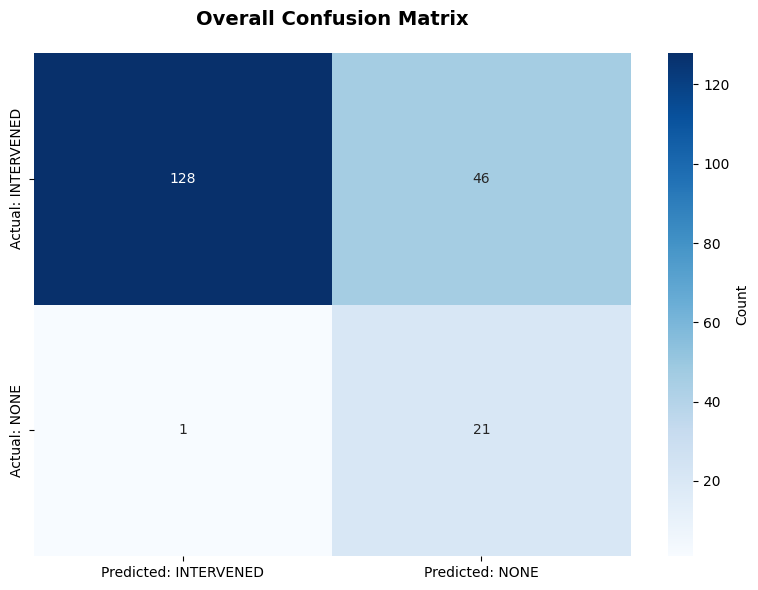

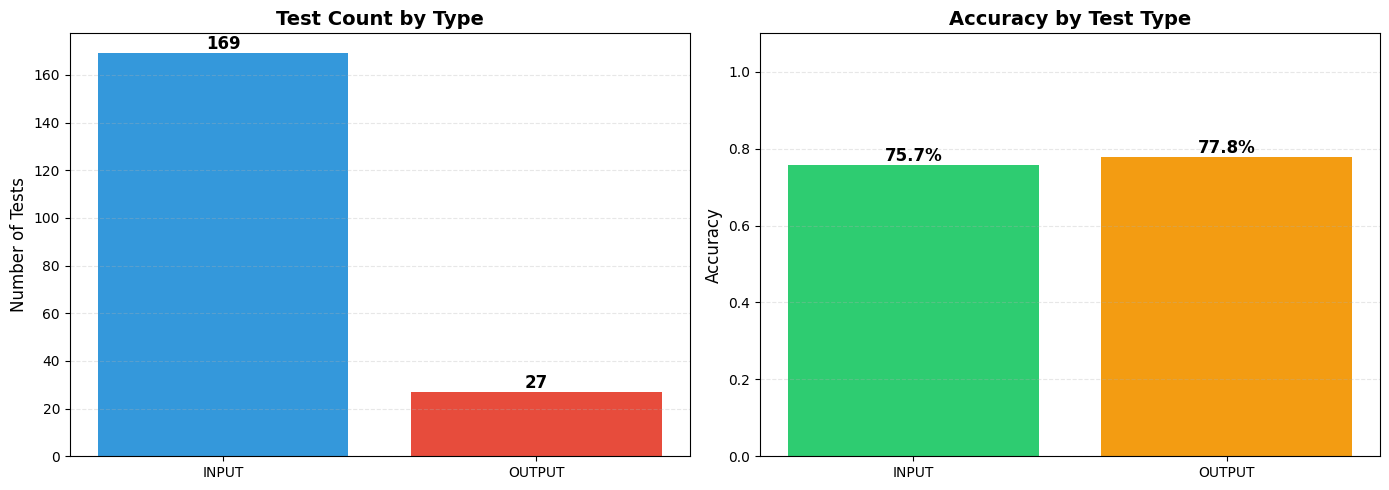

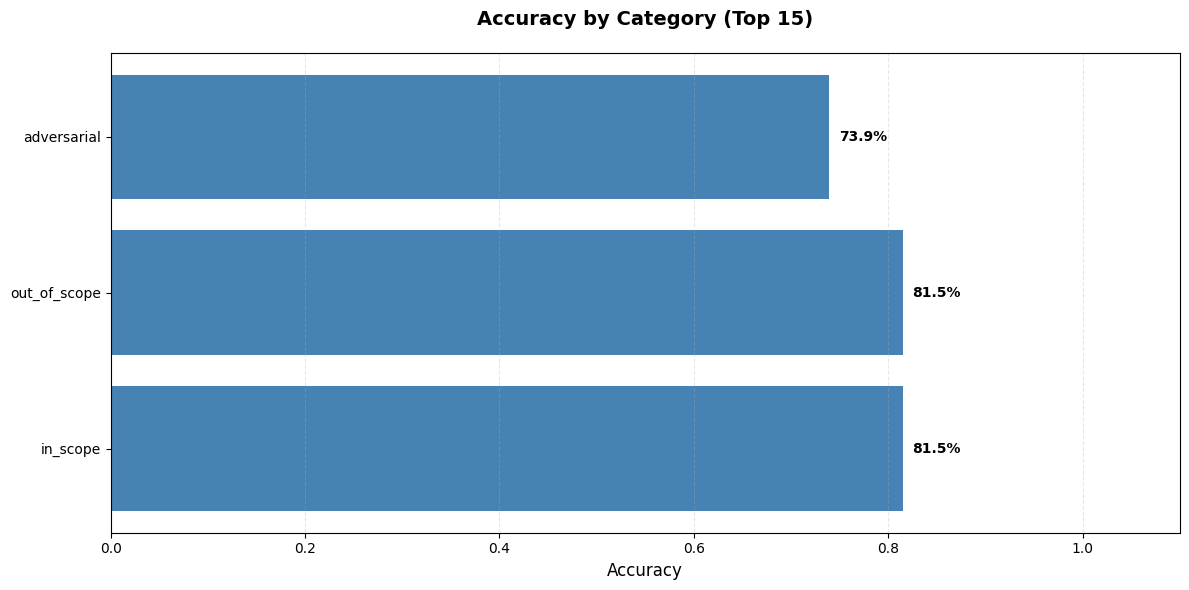

In [5]:
# Visualize results to see how well the Guardrails performed

def calculate_metrics(results_file):
    """Calculate evaluation metrics from the test results."""
    df = pd.read_json(results_file)

    # Calculate overall metrics
    total_tests = len(df)
    # Handle boolean values directly
    correct_predictions = df['achieved_expected_result'] == True
    accuracy = correct_predictions.sum() / total_tests

    # Calculate confusion matrix elements
    # True Positive: Expected GUARDRAIL_INTERVENED and got GUARDRAIL_INTERVENED
    tp = ((df['expected_action'] == 'GUARDRAIL_INTERVENED') &
          (df['test_result'] == 'GUARDRAIL_INTERVENED')).sum()

    # False Positive: Expected NONE but got GUARDRAIL_INTERVENED
    fp = ((df['expected_action'] == 'NONE') &
          (df['test_result'] == 'GUARDRAIL_INTERVENED')).sum()

    # True Negative: Expected NONE and got NONE
    tn = ((df['expected_action'] == 'NONE') &
          (df['test_result'] == 'NONE')).sum()

    # False Negative: Expected GUARDRAIL_INTERVENED but got NONE
    fn = ((df['expected_action'] == 'GUARDRAIL_INTERVENED') &
          (df['test_result'] == 'NONE')).sum()

    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate latency metrics
    latencies = df['guardrailProcessingLatency'].dropna()
    avg_latency = latencies.mean() if len(latencies) > 0 else 0
    min_latency = latencies.min() if len(latencies) > 0 else 0
    max_latency = latencies.max() if len(latencies) > 0 else 0
    median_latency = latencies.median() if len(latencies) > 0 else 0

    metrics = {
        'Total Tests': total_tests,
        'Accuracy': accuracy,
        'True Positives': int(tp),
        'False Positives': int(fp),
        'True Negatives': int(tn),
        'False Negatives': int(fn),
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Average Latency (ms)': avg_latency,
        'Min Latency (ms)': min_latency,
        'Max Latency (ms)': max_latency,
        'Median Latency (ms)': median_latency
    }

    return metrics, df

def analyze_by_category(df):
    """Analyze results by test type (INPUT/OUTPUT) and category if available."""
    results = {}

    # Analyze by test type
    results['by_test_type'] = {}
    for test_type in df['test_type'].unique():
        category_df = df[df['test_type'] == test_type]
        results['by_test_type'][test_type] = calculate_category_metrics(category_df)

    # Analyze by category if column exists
    if 'category' in df.columns:
        results['by_category'] = {}
        for category in df['category'].unique():
            category_df = df[df['category'] == category]
            results['by_category'][category] = calculate_category_metrics(category_df)

    return results

def calculate_category_metrics(category_df):
    """Calculate metrics for a specific category of tests."""
    total = len(category_df)
    # Handle boolean values directly
    correct = (category_df['achieved_expected_result'] == True).sum()
    accuracy = correct / total if total > 0 else 0

    # Calculate confusion matrix
    tp = ((category_df['expected_action'] == 'GUARDRAIL_INTERVENED') &
          (category_df['test_result'] == 'GUARDRAIL_INTERVENED')).sum()
    fp = ((category_df['expected_action'] == 'NONE') &
          (category_df['test_result'] == 'GUARDRAIL_INTERVENED')).sum()
    tn = ((category_df['expected_action'] == 'NONE') &
          (category_df['test_result'] == 'NONE')).sum()
    fn = ((category_df['expected_action'] == 'GUARDRAIL_INTERVENED') &
          (category_df['test_result'] == 'NONE')).sum()

    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate latency metrics for this category
    latencies = category_df['guardrailProcessingLatency'].dropna()
    avg_latency = latencies.mean() if len(latencies) > 0 else 0
    min_latency = latencies.min() if len(latencies) > 0 else 0
    max_latency = latencies.max() if len(latencies) > 0 else 0
    median_latency = latencies.median() if len(latencies) > 0 else 0

    return {
        'Total': int(total),
        'Correct': int(correct),
        'Accuracy': accuracy,
        'TP': int(tp),
        'FP': int(fp),
        'TN': int(tn),
        'FN': int(fn),
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Average Latency (ms)': avg_latency,
        'Min Latency (ms)': min_latency,
        'Max Latency (ms)': max_latency,
        'Median Latency (ms)': median_latency
    }

def plot_confusion_matrix(metrics, title="Overall Confusion Matrix"):
    """Plot confusion matrix as a heatmap."""
    confusion_matrix = np.array([
        [metrics['True Positives'], metrics['False Negatives']],
        [metrics['False Positives'], metrics['True Negatives']]
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted: INTERVENED', 'Predicted: NONE'],
                yticklabels=['Actual: INTERVENED', 'Actual: NONE'],
                cbar_kws={'label': 'Count'}, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

def plot_performance_metrics(metrics, title="Overall Performance Metrics"):
    """Plot precision, recall, F1 score, and accuracy as bar chart."""
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_values = [metrics['Accuracy'], metrics['Precision'],
                     metrics['Recall'], metrics['F1 Score']]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metric_names, metric_values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    return fig

def plot_category_comparison(category_results, result_key='by_category',
                             title="Accuracy by Category", top_n=15):
    """Plot accuracy comparison across categories."""
    if result_key not in category_results or not category_results[result_key]:
        return None

    categories = list(category_results[result_key].keys())
    accuracies = [category_results[result_key][cat]['Accuracy'] for cat in categories]

    # Sort by accuracy
    sorted_data = sorted(zip(categories, accuracies), key=lambda x: x[1], reverse=True)

    # Take top N
    if len(sorted_data) > top_n:
        sorted_data = sorted_data[:top_n]

    categories, accuracies = zip(*sorted_data) if sorted_data else ([], [])

    fig, ax = plt.subplots(figsize=(12, max(6, len(categories) * 0.4)))
    bars = ax.barh(range(len(categories)), accuracies, color='steelblue')

    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax.text(acc + 0.01, i, f'{acc:.1%}',
                va='center', fontsize=10, fontweight='bold')

    ax.set_yticks(range(len(categories)))
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xlabel('Accuracy', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 1.1)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    return fig

def plot_test_type_distribution(category_results):
    """Plot test type distribution with metrics."""
    if 'by_test_type' not in category_results:
        return None

    test_types = list(category_results['by_test_type'].keys())
    if not test_types:
        return None

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Test counts by type
    totals = [category_results['by_test_type'][tt]['Total'] for tt in test_types]
    axes[0].bar(test_types, totals, color=['#3498db', '#e74c3c'])
    axes[0].set_ylabel('Number of Tests', fontsize=12)
    axes[0].set_title('Test Count by Type', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')

    for i, (tt, total) in enumerate(zip(test_types, totals)):
        axes[0].text(i, total, str(total), ha='center', va='bottom',
                    fontsize=12, fontweight='bold')

    # Plot 2: Accuracy comparison by type
    accuracies = [category_results['by_test_type'][tt]['Accuracy'] for tt in test_types]
    bars = axes[1].bar(test_types, accuracies, color=['#2ecc71', '#f39c12'])
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy by Test Type', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 1.1)
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')

    for i, (tt, acc) in enumerate(zip(test_types, accuracies)):
        axes[1].text(i, acc, f'{acc:.1%}', ha='center', va='bottom',
                    fontsize=12, fontweight='bold')

    plt.tight_layout()
    return fig

def display_results(results_file, show_plots=True):
    """Display comprehensive evaluation results with visualizations."""
    print("\n" + "="*60)
    print("GUARDRAIL EVALUATION RESULTS")
    print("="*60)

    metrics, df = calculate_metrics(results_file)

    # Print overall metrics
    print("\nOVERALL METRICS:")
    print("-"*60)
    print(f"{'Total Tests':<20s}: {metrics['Total Tests']}")
    print(f"{'Accuracy':<20s}: {metrics['Accuracy']:.2%}")
    print(f"{'True Positives':<20s}: {metrics['True Positives']}")
    print(f"{'False Positives':<20s}: {metrics['False Positives']}")
    print(f"{'True Negatives':<20s}: {metrics['True Negatives']}")
    print(f"{'False Negatives':<20s}: {metrics['False Negatives']}")
    print(f"{'Precision':<20s}: {metrics['Precision']:.2%}")
    print(f"{'Recall':<20s}: {metrics['Recall']:.2%}")
    print(f"{'F1 Score':<20s}: {metrics['F1 Score']:.2%}")
    print(f"\n{'LATENCY METRICS:':<20s}")
    print(f"{'Avg Latency (ms)':<20s}: {metrics['Average Latency (ms)']:.2f}")
    print(f"{'Min Latency (ms)':<20s}: {metrics['Min Latency (ms)']:.2f}")
    print(f"{'Max Latency (ms)':<20s}: {metrics['Max Latency (ms)']:.2f}")
    print(f"{'Median Latency (ms)':<20s}: {metrics['Median Latency (ms)']:.2f}")

    category_results = analyze_by_category(df)

    # Print metrics by test type
    print("\n\nMETRICS BY TEST TYPE:")
    print("-"*60)
    for test_type, stats in category_results['by_test_type'].items():
        print(f"\n{test_type}:")
        print(f"  {'Total':<15s}: {stats['Total']}")
        print(f"  {'Correct':<15s}: {stats['Correct']}")
        print(f"  {'Accuracy':<15s}: {stats['Accuracy']:.2%}")
        print(f"  {'Precision':<15s}: {stats['Precision']:.2%}")
        print(f"  {'Recall':<15s}: {stats['Recall']:.2%}")
        print(f"  {'F1 Score':<15s}: {stats['F1 Score']:.2%}")
        print(f"  {'TP/FP/TN/FN':<15s}: {stats['TP']}/{stats['FP']}/{stats['TN']}/{stats['FN']}")
        print(f"  {'Avg Latency (ms)':<15s}: {stats['Average Latency (ms)']:.2f}")

    # Print metrics by category (top 10)
    if 'by_category' in category_results:
        print("\n\nMETRICS BY CATEGORY (Top 10 by test count):")
        print("-"*60)

        # Sort categories by total count
        sorted_categories = sorted(
            category_results['by_category'].items(),
            key=lambda x: x[1]['Total'],
            reverse=True
        )[:10]

        for category, stats in sorted_categories:
            print(f"\n{category}:")
            print(f"  {'Total':<15s}: {stats['Total']}")
            print(f"  {'Correct':<15s}: {stats['Correct']}")
            print(f"  {'Accuracy':<15s}: {stats['Accuracy']:.2%}")
            print(f"  {'Avg Latency (ms)':<15s}: {stats['Average Latency (ms)']:.2f}")

    # Show sample failed tests
    failed_tests = df[df['achieved_expected_result'] == False]
    if len(failed_tests) > 0:
        print(f"\n\nFAILED TESTS SAMPLE (showing up to 5 of {len(failed_tests)} failures):")
        print("-"*60)
        for idx, row in failed_tests.head(5).iterrows():
            print(f"\nTest #{row['test_number']} ({row['test_type']}) - Category: {row.get('category', 'N/A')}")
            query_text = str(row['test_content_query'])[:100]
            print(f"  Query: {query_text}{'...' if len(str(row['test_content_query'])) > 100 else ''}")
            print(f"  Expected: {row['expected_action']}")
            print(f"  Got: {row['test_result']}")

    print("\n" + "="*60)

    # Generate visualizations
    if show_plots:
        print("\nGenerating visualizations...")

        # 1. Confusion Matrix
        fig1 = plot_confusion_matrix(metrics)
        plt.show()

        # 2. Test Type Distribution
        fig2 = plot_test_type_distribution(category_results)
        if fig2:
            plt.show()

        # 3. Category Comparison (if categories exist)
        if 'by_category' in category_results and category_results['by_category']:
            fig3 = plot_category_comparison(category_results, 'by_category',
                                           'Accuracy by Category (Top 15)', top_n=15)
            if fig3:
                plt.show()

    return metrics, df, category_results

# Display the evaluation results with visualizations
metrics, df, category_results = display_results(output_file, show_plots=True)

## Confusion matrix results

1. Top-left / True Positives:
   - Where "Actual: INTERVENED" and "Predicted: INTERVENED" intersect
   - Cases where the guardrail correctly intervened when it should have

2. Top-right / False Negatives:
   - Where "Actual: INTERVENED" and "Predicted: NONE" intersect
   - Cases where the guardrail should have intervened but didn't

3. Bottom-left / False Positives:
   - Where "Actual: NONE" and "Predicted: INTERVENED" intersect
   - Cases where the guardrail intervened but should not have

4. Bottom-right / True Negatives:
   - Where "Actual: NONE" and "Predicted: NONE" intersect
   - Cases where the guardrail correctly allowed content to pass through